<a href="https://colab.research.google.com/github/melyneca/Calendar/blob/main/Ship_Classify_03.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Önce uygun kütüphaneler yüklenir


In [1]:
import torch
import torchvision.transforms as transforms
import pandas as pd
import os
from torch.utils.data import Dataset
from skimage import io
import torchvision
import numpy as np
import torch.nn as nn


Zip dosyası açılır ve extractall() ile dosyalar dışarı çıkarılır

In [2]:
from zipfile import ZipFile
  
# Zip file directory
file_name = "/content/archive (1).zip"
  
# opening the zip file in READ mode
with ZipFile(file_name, 'r') as zip:
    # extracting all the files
    zip.extractall()

In [3]:
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

In [4]:
class ShipLoad(Dataset):
  def __init__(self, csv_file, root_dir, transform=None):
    self.annotations = pd.read_csv(csv_file)
    self.root_dir = root_dir
    self.transform = transform

  def __len__(self):
    return len(self.annotations)

  def __getitem__(self, index):
    img_path = os.path.join(self.root_dir, self.annotations.iloc[index, 0])
    image = io.imread(img_path)
    
    y_label = torch.tensor(int(self.annotations.iloc[index, 1])-1)

    if self.transform:
      image = self.transform(image)

    return (image, y_label)

In [5]:
transform= transforms.Compose(
        [transforms.ToPILImage(),
        transforms.Resize((128,128)),
        transforms.Grayscale(num_output_channels=1),
        transforms.ToTensor(),
        transforms.Normalize((0.5),(0.2))
        ])

In [6]:
train_set = ShipLoad('/content/train/train.csv', root_dir ='/content/train/images', transform = transform)
test_set = ShipLoad('/content/train/train.csv', root_dir ='/content/train/images', transform = transform)

In [7]:
image, label = train_set[3]

In [8]:
image.shape

torch.Size([1, 128, 128])

In [9]:
classes = ['Cargo','Military','Carrier','Cruise','Tankers']

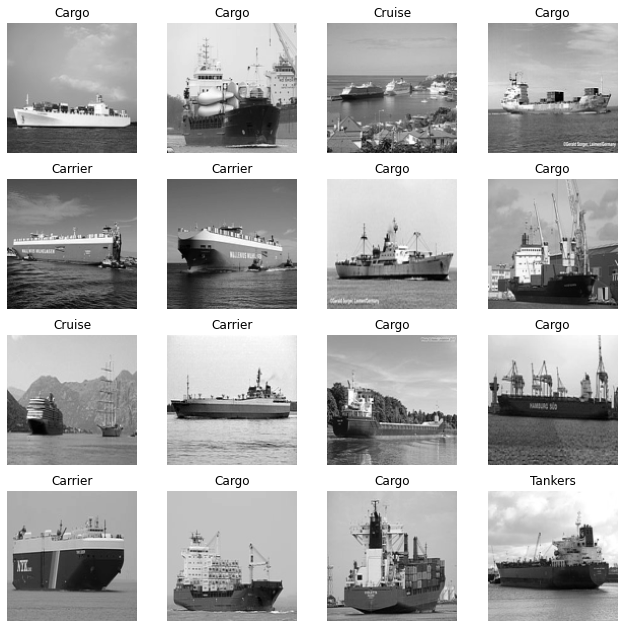

In [10]:
import matplotlib.pyplot as plt
import random

fig = plt.figure(figsize=(11,11))

for i in range(1,17):
  id = random.randint(0,len(train_set))
  images, label = train_set[id] 
  fig.add_subplot(4, 4, i)
  plt.imshow(images.squeeze(), cmap="gray")
  plt.axis('off');
  plt.title(classes[label]);


In [11]:
from torch.utils.data import DataLoader

DataLoadder kullanılarak resimler batchler halinde yüklenir


In [12]:
train_data = DataLoader(dataset = train_set, batch_size= 32, shuffle= True)
test_data = DataLoader(dataset = test_set, batch_size= 32)

In [13]:
image = torch.rand(size=[32,1,128,128])

In [14]:
class CNN(nn.Module):
    def __init__(self, input_shape: int, hidden_units: int, output_shape: int):
        super().__init__()
        self.block_1 = nn.Sequential(
            nn.Conv2d(in_channels=input_shape, 
                      out_channels=hidden_units, 
                      kernel_size=3, # how big is the square that's going over the image?
                      stride=1, # default
                      padding=1),# options = "valid" (no padding) or "same" (output has same shape as input) or int for specific number 
            nn.ReLU(),
            nn.Conv2d(in_channels=hidden_units, 
                      out_channels=hidden_units,
                      kernel_size=3,
                      stride=1,
                      padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2,
                         stride=2) # default stride value is same as kernel_size
        )
        self.block_2 = nn.Sequential(
            nn.Conv2d(hidden_units, hidden_units, 3, padding=1),
            nn.ReLU(),
            nn.Conv2d(hidden_units, hidden_units, 3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2)
        )
        self.classifier = nn.Sequential(
            nn.Flatten(),
            # Where did this in_features shape come from? 
            # It's because each layer of our network compresses and changes the shape of our inputs data.
            nn.Linear(in_features=(hidden_units*32*32), 
                      out_features=output_shape)
        )
    
    def forward(self, x: torch.Tensor):
        x = self.block_1(x)
        x = self.block_2(x)
        x = self.classifier(x)

        return x

In [15]:
modelCNN = CNN(input_shape=1, hidden_units= 10, output_shape= 5).to(device)

In [29]:
loss_fn = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(params=modelCNN.parameters(), lr=0.1)

In [17]:
def accuracy_fn(y_true, y_pred):
    correct = torch.eq(y_true, y_pred).sum().item() # torch.eq() calculates where two tensors are equal
    acc = (correct / len(y_pred)) * 100 
    return acc

In [21]:
epochs = 10

In [30]:
for epoch in range(epochs):
    print(f"Epoch: {epoch}\n-------")
    ### Training
    train_loss = 0
    acc = 0
    # Add a loop to loop through training batches
    for batch, (image, label) in enumerate(train_data):
        modelCNN.train() 
        image = image.to(device)
        label = label.type(torch.long).to(device)
         
        # 1. Forward pass
        label_pred = modelCNN(image)

        # 2. Calculate loss (per batch)
        loss = loss_fn(label_pred, label)
        train_loss += loss
        acc += accuracy_fn(y_true=label, y_pred= label_pred.argmax(dim=1)) 

        # 3. Optimizer zero grad
        optimizer.zero_grad()

        # 4. Loss backward
        loss.backward()

        # 5. Optimizer step
        optimizer.step()

    acc = acc/len(train_data)
    train_loss = train_loss/len(train_data)
    print(acc)
    print(train_loss)
        

Epoch: 0
-------
33.76913265306123
tensor(1.5496, device='cuda:0', grad_fn=<DivBackward0>)
Epoch: 1
-------
37.32461734693877
tensor(1.4753, device='cuda:0', grad_fn=<DivBackward0>)
Epoch: 2
-------
46.136267006802726
tensor(1.3258, device='cuda:0', grad_fn=<DivBackward0>)
Epoch: 3
-------
50.488945578231295
tensor(1.2238, device='cuda:0', grad_fn=<DivBackward0>)
Epoch: 4
-------
56.66985544217687
tensor(1.1019, device='cuda:0', grad_fn=<DivBackward0>)
Epoch: 5
-------
62.56377551020408
tensor(0.9605, device='cuda:0', grad_fn=<DivBackward0>)
Epoch: 6
-------
67.72427721088435
tensor(0.8244, device='cuda:0', grad_fn=<DivBackward0>)
Epoch: 7
-------
70.93431122448979
tensor(0.7485, device='cuda:0', grad_fn=<DivBackward0>)
Epoch: 8
-------
76.51466836734694
tensor(0.6233, device='cuda:0', grad_fn=<DivBackward0>)
Epoch: 9
-------
79.35267857142857
tensor(0.5464, device='cuda:0', grad_fn=<DivBackward0>)
